# Example - A Simple Regression

In [1]:
from funflow import Model, GridMap, Functional, TemplateValue, Template, Tag, ValueTagFilter

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoLars
import networkx as nx
from IPython.display import Image

In [3]:
dataset = fetch_california_housing()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
target = dataset['target']
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3, random_state=42)

In [5]:
untrained_model_template = Template("untrained_model")
trained_model_template = Template("trained_model")
trained_boosted_model_template = Template("trained_boosted_model")

simple_prediction_template = Template("predictions", [Tag("model_type", "simple")])
boosted_prediction_template = Template("predictions", [Tag("model_type", "boosted")])

fit_layer = Functional(lambda model, X, y: model.fit(X, y), 
                       inputs=[untrained_model_template, "X_train", "y_train"], 
                       outputs=[trained_model_template], 
                       call_type="args", debug=False, name="Fit Simple")

predict_simple_layer = Functional(lambda model, X: model.predict(X), 
                                  inputs=[trained_model_template, "X_test"], 
                                  outputs=[simple_prediction_template], 
                                  call_type="args", debug=False, name="Predict Simple")

merge_X = lambda X, y_pred: np.hstack([X, y_pred.reshape((-1, 1))])
fit_boosting_layer = Functional(lambda model, X, y: RandomForestRegressor(n_estimators=10, n_jobs=-1).fit(merge_X(X, model.predict(X)), y), 
                                inputs=[trained_model_template, "X_train", "y_train"], 
                                outputs=[trained_boosted_model_template], 
                                call_type="args", debug=False, name="Fit Boost")

predict_boosted_layer = Functional(lambda boost_model, simple_model, X: boost_model.predict(merge_X(X, simple_model.predict(X))), 
                                   inputs=[trained_boosted_model_template, trained_model_template, "X_test"], 
                                   outputs=[boosted_prediction_template], 
                                   call_type="args", debug=False, name="Predict Boost")

model_layer = Model([fit_layer, fit_boosting_layer, predict_simple_layer, predict_boosted_layer], 
                    inputs=[untrained_model_template, "X_train", "y_train", "X_test"], 
                    outputs=[trained_model_template, simple_prediction_template, trained_boosted_model_template, boosted_prediction_template], 
                    debug=False)

In [6]:
model_inputs = {
    "untrained_model": LinearRegression(),
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
}

In [7]:
model_inputs.keys()

dict_keys(['untrained_model', 'X_train', 'y_train', 'X_test'])

In [8]:
model_outputs = model_layer(**model_inputs)
model_outputs

{'trained_model': LinearRegression(),
 'predictions, model_type: simple': array([0.72604907, 1.76743383, 2.71092161, ..., 2.07465531, 1.57371395,
        1.82744133]),
 'trained_boosted_model': RandomForestRegressor(n_estimators=10, n_jobs=-1),
 'predictions, model_type: boosted': array([0.5343  , 0.6776  , 4.750006, ..., 2.0576  , 1.2532  , 2.3301  ])}

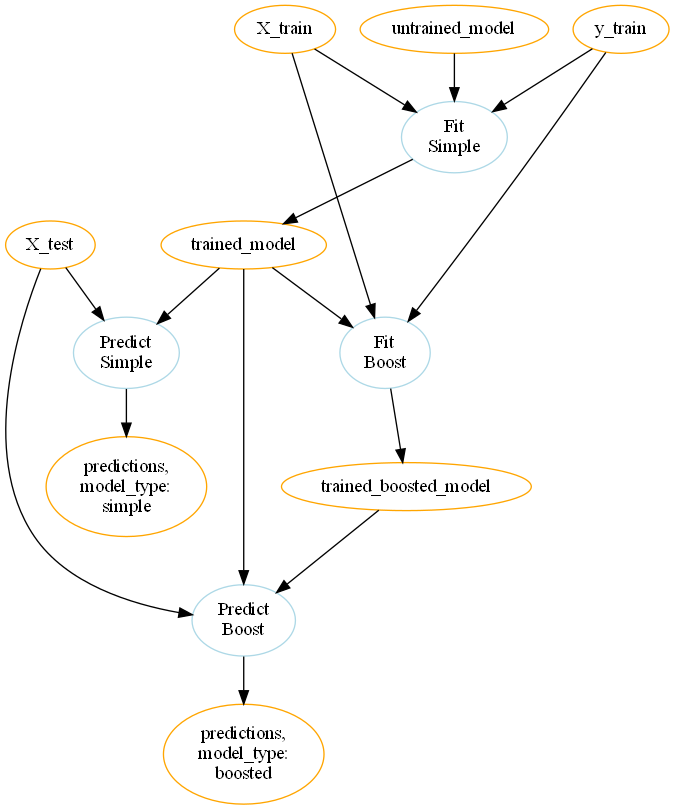

In [9]:
G = model_layer.create_graph(model_inputs)
A = nx.nx_agraph.to_agraph(G)
A.draw('simple_regression.png', prog="dot")
Image('simple_regression.png')

In [10]:
def no_templates(layer):
    def call_layer(*args):
        kwargs = dict(zip(map(str, layer.inputs), args))
        result = layer(**kwargs)
        return tuple(result[str(output_name)] for output_name in layer.outputs)
    return call_layer

In [11]:
print(model_layer)
no_templates(model_layer)(LinearRegression(), X_train, y_train, X_test)

Model Model: 5, 
- Inputs: [Template("untrained_model", [], [...filters...]), Template("X_train", [], [...filters...]), Template("y_train", [], [...filters...]), Template("X_test", [], [...filters...])] -> [TemplateValue("untrained_model", []), TemplateValue("X_train", []), TemplateValue("y_train", []), TemplateValue("X_test", [])], 
- Outputs: [Template("trained_model", [], [...filters...]), Template("predictions", ["model_type"= Tag("model_type", "simple")], [...filters...]), Template("trained_boosted_model", [], [...filters...]), Template("predictions", ["model_type"= Tag("model_type", "boosted")], [...filters...])] -> [TemplateValue("trained_model", []), TemplateValue("predictions", ["model_type"= Tag("model_type", "simple")]), TemplateValue("trained_boosted_model", []), TemplateValue("predictions", ["model_type"= Tag("model_type", "boosted")])] 
- Predecessors: []


(LinearRegression(),
 array([0.72604907, 1.76743383, 2.71092161, ..., 2.07465531, 1.57371395,
        1.82744133]),
 RandomForestRegressor(n_estimators=10, n_jobs=-1),
 array([0.5075  , 0.7483  , 4.741707, ..., 2.363   , 1.2774  , 2.4176  ]))

In [12]:
def normalize(train, test):
    train_mean = np.mean(train)
    train_std = np.std(train)

    train_norm = (train - train_mean) / train_std
    test_norm = (test - train_mean) / train_std
    return train_norm, test_norm, train_mean, train_std


def denormalize(data, mean, std):
    return data * std + mean

In [13]:
# GridMap(lambda x, y: (x*y, ), inputs=["x", "y"], outputs=[Template("xy", filters=[NoTagFilter("a"), NoTagFilter("b")])])(**{
GridMap(lambda x, y, z: (f"{z} {x*y}", ), 
        inputs=["x", "y", "z"], 
        outputs=[Template("zxy", [Tag("f", "null")], [ValueTagFilter("b", "100")])])(**{
    "x, a:1": 1,
    "x, a:2": 2,
    "x, a:3": 3,
    "x, a:4": 4,
    "y, b:1": 1,
    "y, b:10": 10,
    "y, b:100": 100,
    "y, b:1000": 1000,
    "z, c:-": "-",
    "z, c:#": "#",
    "z, c:*": "*",    
})

{'zxy, a: 4, b: 100, c: #, f: null': '# 400',
 'zxy, a: 4, b: 100, c: -, f: null': '- 400',
 'zxy, a: 4, b: 100, c: *, f: null': '* 400',
 'zxy, a: 1, b: 100, c: #, f: null': '# 100',
 'zxy, a: 1, b: 100, c: -, f: null': '- 100',
 'zxy, a: 1, b: 100, c: *, f: null': '* 100',
 'zxy, a: 2, b: 100, c: #, f: null': '# 200',
 'zxy, a: 2, b: 100, c: -, f: null': '- 200',
 'zxy, a: 2, b: 100, c: *, f: null': '* 200',
 'zxy, a: 3, b: 100, c: #, f: null': '# 300',
 'zxy, a: 3, b: 100, c: -, f: null': '- 300',
 'zxy, a: 3, b: 100, c: *, f: null': '* 300'}

In [14]:
GridMap(lambda x, mu, std: (x * std + mu, ), 
        inputs=["x", "mu", "std"], 
        outputs="x_denorm")(**{
    "x, a:1": 1,
    "x, a:2": 2,
    "x, a:3": 3,
    "x, a:4": 4,
    "mu": 1,
    "std": 10,
})

{'x_denorm, a: 4': 41,
 'x_denorm, a: 1': 11,
 'x_denorm, a: 2': 21,
 'x_denorm, a: 3': 31}

In [16]:
X_train_raw_template = Template("X_train", filters=[ValueTagFilter("dataset_type", "raw")])
y_train_raw_template = Template("y_train", filters=[ValueTagFilter("dataset_type", "raw")])
X_test_raw_template = Template("X_test", filters=[ValueTagFilter("dataset_type", "raw")])
y_test_raw_template = Template("y_test", filters=[ValueTagFilter("dataset_type", "raw")])

X_train_norm_template = Template("X_train", [Tag("dataset_type", "normalized")])
y_train_norm_template = Template("y_train", [Tag("dataset_type", "normalized")])
X_test_norm_template = Template("X_test", [Tag("dataset_type", "normalized")])
y_test_norm_template = Template("y_test", [Tag("dataset_type", "normalized")])
    
norm_X_layer = Functional(normalize, 
                          name="NormalizeX",
                          inputs=[X_train_raw_template, X_test_raw_template], 
                          outputs=[X_train_norm_template, X_test_norm_template, "X_train_mean", "X_train_std"],
                          call_type="args", 
                          debug=False
                          )

norm_y_layer = Functional(normalize, 
                          name="NormalizeY",
                          inputs=[y_train_raw_template, y_test_raw_template], 
                          outputs=[y_train_norm_template, y_test_norm_template, "y_train_mean", "y_train_std"],
                          call_type="args", 
                          debug=False
                          )

finalise_layer_norm = GridMap(denormalize,
                              name="Finalise-Norm",
                              inputs=[Template("predictions", filters=[ValueTagFilter("dataset_type", "normalized")]), "y_train_mean", "y_train_std"],
                              outputs=["result"], 
                              debug=True
                              )

finalise_layer_raw = GridMap(lambda x: x,
                             name="Finalise-Raw",
                             inputs=[Template("predictions", filters=[ValueTagFilter("dataset_type", "raw")])],
                             outputs=["result"], 
                             debug=True
                             )

map_models = GridMap(no_templates(model_layer),
                     name="Map-Model", 
                     inputs=[untrained_model_template, "X_train", "y_train", "X_test"], 
                     outputs=[trained_model_template, simple_prediction_template, trained_boosted_model_template, boosted_prediction_template], 
                     func_input_type="args", func_output_type="tuple", debug=False)

# rename_layer = Rename({"X_train": "X_train - Raw", "y_train": "y_train - Raw", "X_test": "X_test - Raw", "y_test": "y_test - Raw"})

select_prediction = Functional(lambda **kwargs: pd.DataFrame(kwargs),
                               name="Select Prediction",
                               inputs=[Template("result")], 
                               outputs=["Pred DataFrame"])

model = Model([norm_X_layer, norm_y_layer, finalise_layer_norm, finalise_layer_raw, map_models, select_prediction],
              name="Pipeline", 
              inputs=[untrained_model_template, "X_train", "y_train", "X_test", "y_test"], 
              outputs=["Pred DataFrame"])

model_inputs = {
    "untrained_model, type: Linear": LinearRegression(),
    "untrained_model, type: LassoLars": LassoLars(),
    "untrained_model, type: RandomForest": RandomForestRegressor(n_estimators=10, n_jobs=-1),
    "X_train, dataset_type: raw": X_train,
    "y_train, dataset_type: raw": y_train,
    "X_test, dataset_type: raw": X_test,
    "y_test, dataset_type: raw": y_test,
}

result = model(**model_inputs)
df = result["Pred DataFrame"]
df

C:\Users\miche\anaconda3\envs\flow\Lib\site-packages\numpy\core\fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Executing layer: Finalise-Norm
- Input: {'predictions, dataset_type: normalized, model_type: simple, type: Linear': array([-1.16047155, -0.26075007,  0.55439172, ...,  0.00467898,
       -0.42811754, -0.2089056 ]), 'predictions, dataset_type: normalized, model_type: boosted, type: Linear': array([-1.3546472 , -0.90693979,  2.40033065, ...,  0.04471924,
       -0.43158546,  0.2930232 ]), 'predictions, dataset_type: normalized, model_type: simple, type: RandomForest': array([-1.38911946, -0.97311962,  2.17232732, ...,  0.08774477,
       -0.51875967,  0.17137672]), 'predictions, dataset_type: normalized, model_type: boosted, type: RandomForest': array([-1.42454209, -0.98988057,  2.49216942, ..., -0.03882631,
       -0.51443984,  0.159022  ]), 'predictions, dataset_type: normalized, model_type: simple, type: LassoLars': array([-1.52455875e-16, -1.52455875e-16, -1.52455875e-16, ...,
       -1.52455875e-16, -1.52455875e-16, -1.52455875e-16]), 'predictions, dataset_type: normalized, model_ty

,"result, dataset_type: normalized, model_type: simple, type: LassoLars","result, dataset_type: normalized, model_type: boosted, type: LassoLars","result, dataset_type: normalized, model_type: boosted, type: Linear","result, dataset_type: normalized, model_type: simple, type: RandomForest","result, dataset_type: normalized, model_type: simple, type: Linear","result, dataset_type: normalized, model_type: boosted, type: RandomForest","result, dataset_type: raw, model_type: boosted, type: Linear","result, dataset_type: raw, model_type: boosted, type: RandomForest","result, dataset_type: raw, model_type: simple, type: RandomForest","result, dataset_type: raw, model_type: simple, type: LassoLars","result, dataset_type: raw, model_type: boosted, type: LassoLars","result, dataset_type: raw, model_type: simple, type: Linear"
0,2.06924,0.515400,0.501300,0.461400,0.726049,0.420400,0.502500,0.419300,0.471400,1.724850,0.510600,0.726049
1,2.06924,0.775400,1.019500,0.942900,1.767434,0.923500,0.654100,0.672500,0.751000,1.878835,0.666500,1.767434
2,2.06924,4.866706,4.847508,4.583605,2.710922,4.953807,4.639304,4.950002,4.766705,2.151020,5.000008,2.710922
3,2.06924,2.642500,2.738200,2.332000,2.835147,2.348300,2.432200,2.617300,2.622700,2.272701,2.657700,2.835147
4,2.06924,2.540400,2.435800,2.185900,2.606958,2.111400,2.314900,2.321000,2.333500,2.081234,2.199600,2.606958
...,...,...,...,...,...,...,...,...,...,...,...,...
6187,2.06924,2.107500,2.130200,2.181300,2.219941,2.149500,2.222700,1.998400,1.987800,2.047928,2.399100,2.219941
6188,2.06924,0.669200,0.683600,0.676000,0.910516,0.637200,0.690400,0.661600,0.676100,1.794109,0.681500,0.910516
6189,2.06924,2.104400,2.121000,2.170800,2.074655,2.024300,2.400000,1.830500,1.926900,1.920519,1.924600,2.074655
6190,2.06924,1.371900,1.569700,1.468800,1.573714,1.473800,1.347800,1.259300,1.310900,1.899937,1.715100,1.573714


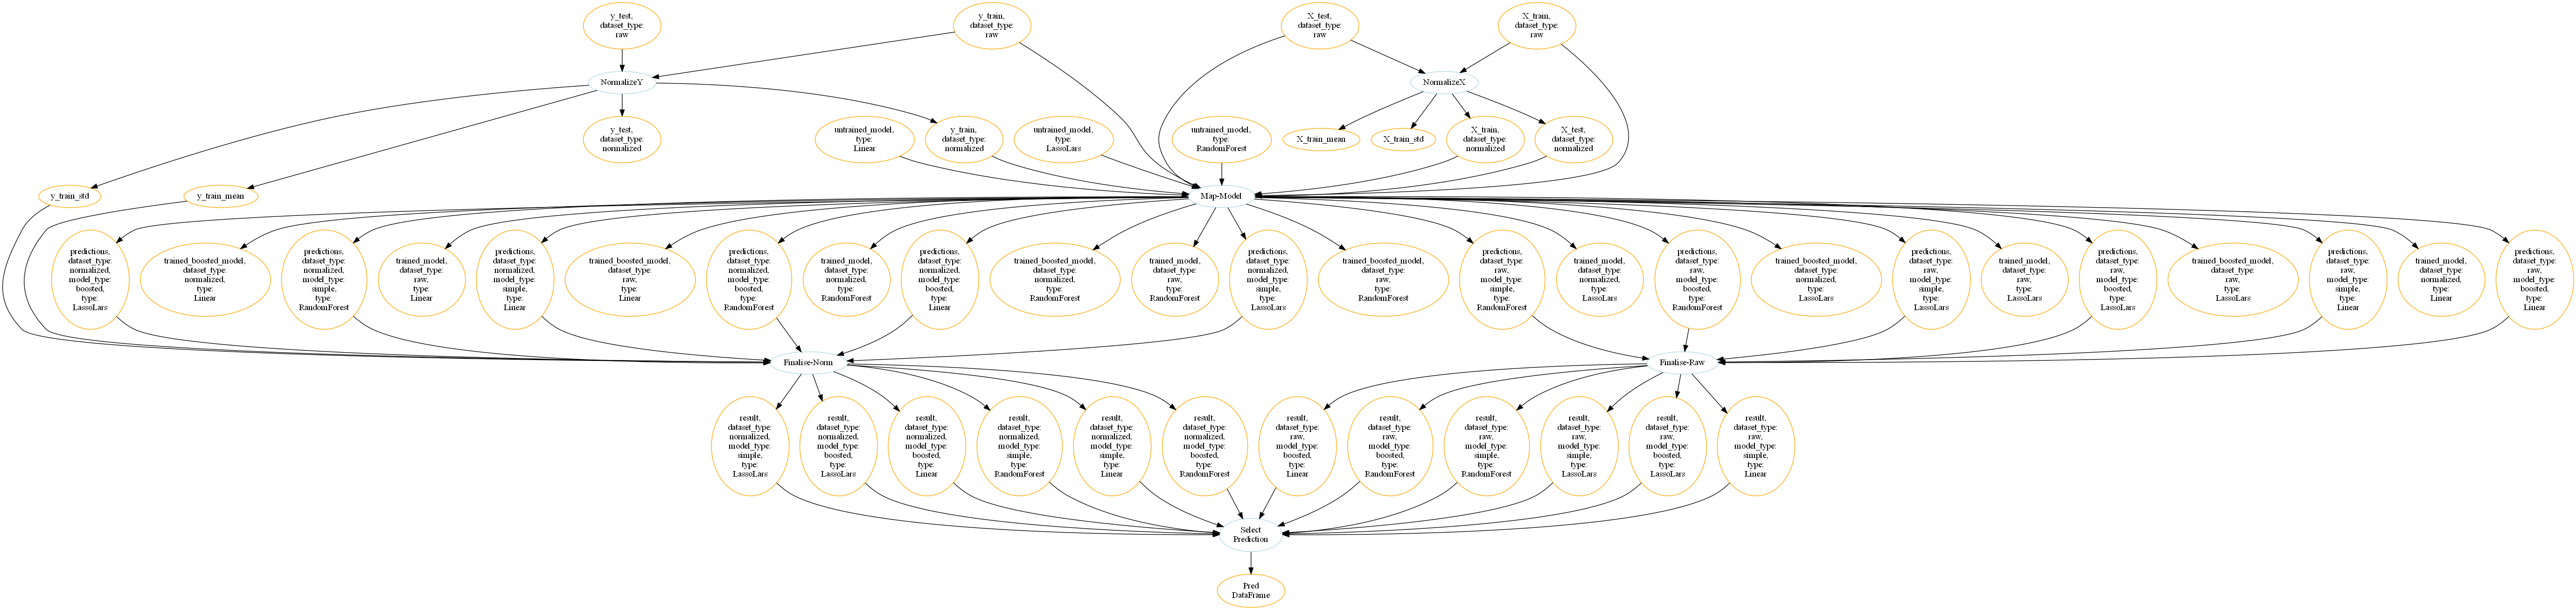

In [17]:
G = model.create_graph(model_inputs)
A = nx.nx_agraph.to_agraph(G)
A.draw('simple_regression.png', prog="dot")
Image('simple_regression.png')

In [18]:
(df
 .subtract(y_test.reshape((-1, 1)))
 # .drop(columns=["y_test"])
 .pipe(np.abs)
 .describe()
 .round(3)
 .sort_values("75%", axis=1)
 )

,"result, dataset_type: raw, model_type: simple, type: RandomForest","result, dataset_type: normalized, model_type: boosted, type: LassoLars","result, dataset_type: raw, model_type: boosted, type: RandomForest","result, dataset_type: normalized, model_type: simple, type: RandomForest","result, dataset_type: raw, model_type: boosted, type: Linear","result, dataset_type: raw, model_type: boosted, type: LassoLars","result, dataset_type: normalized, model_type: boosted, type: RandomForest","result, dataset_type: normalized, model_type: boosted, type: Linear","result, dataset_type: normalized, model_type: simple, type: Linear","result, dataset_type: raw, model_type: simple, type: Linear","result, dataset_type: raw, model_type: simple, type: LassoLars","result, dataset_type: normalized, model_type: simple, type: LassoLars"
count,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000
mean,0.346,0.348,0.350,0.350,0.354,0.352,0.354,0.355,0.527,0.527,0.761,0.906
std,0.398,0.397,0.410,0.400,0.401,0.400,0.411,0.398,0.503,0.503,0.596,0.701
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001
25%,0.089,0.090,0.085,0.088,0.091,0.089,0.087,0.092,0.196,0.196,0.314,0.378
50%,0.217,0.218,0.210,0.220,0.226,0.219,0.215,0.227,0.409,0.409,0.645,0.756
75%,0.453,0.456,0.458,0.461,0.464,0.468,0.469,0.471,0.689,0.689,1.048,1.236
max,3.420,3.440,3.401,3.459,4.045,3.459,3.875,3.783,9.882,9.882,3.424,2.931


In [43]:
result_df = (df
 .assign(y_true = y_test)
 .melt("y_true")
 .pipe(lambda x: pd.concat([x,
                            pd.DataFrame(x["variable"].apply(lambda v: TemplateValue(v).to_dict()).values.tolist())
                            ], axis=1)
       )
 .drop(columns="variable")
)

C:\Users\miche\anaconda3\envs\flow\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\miche\anaconda3\envs\flow\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\miche\anaconda3\envs\flow\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\miche\anaconda3\envs\flow\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

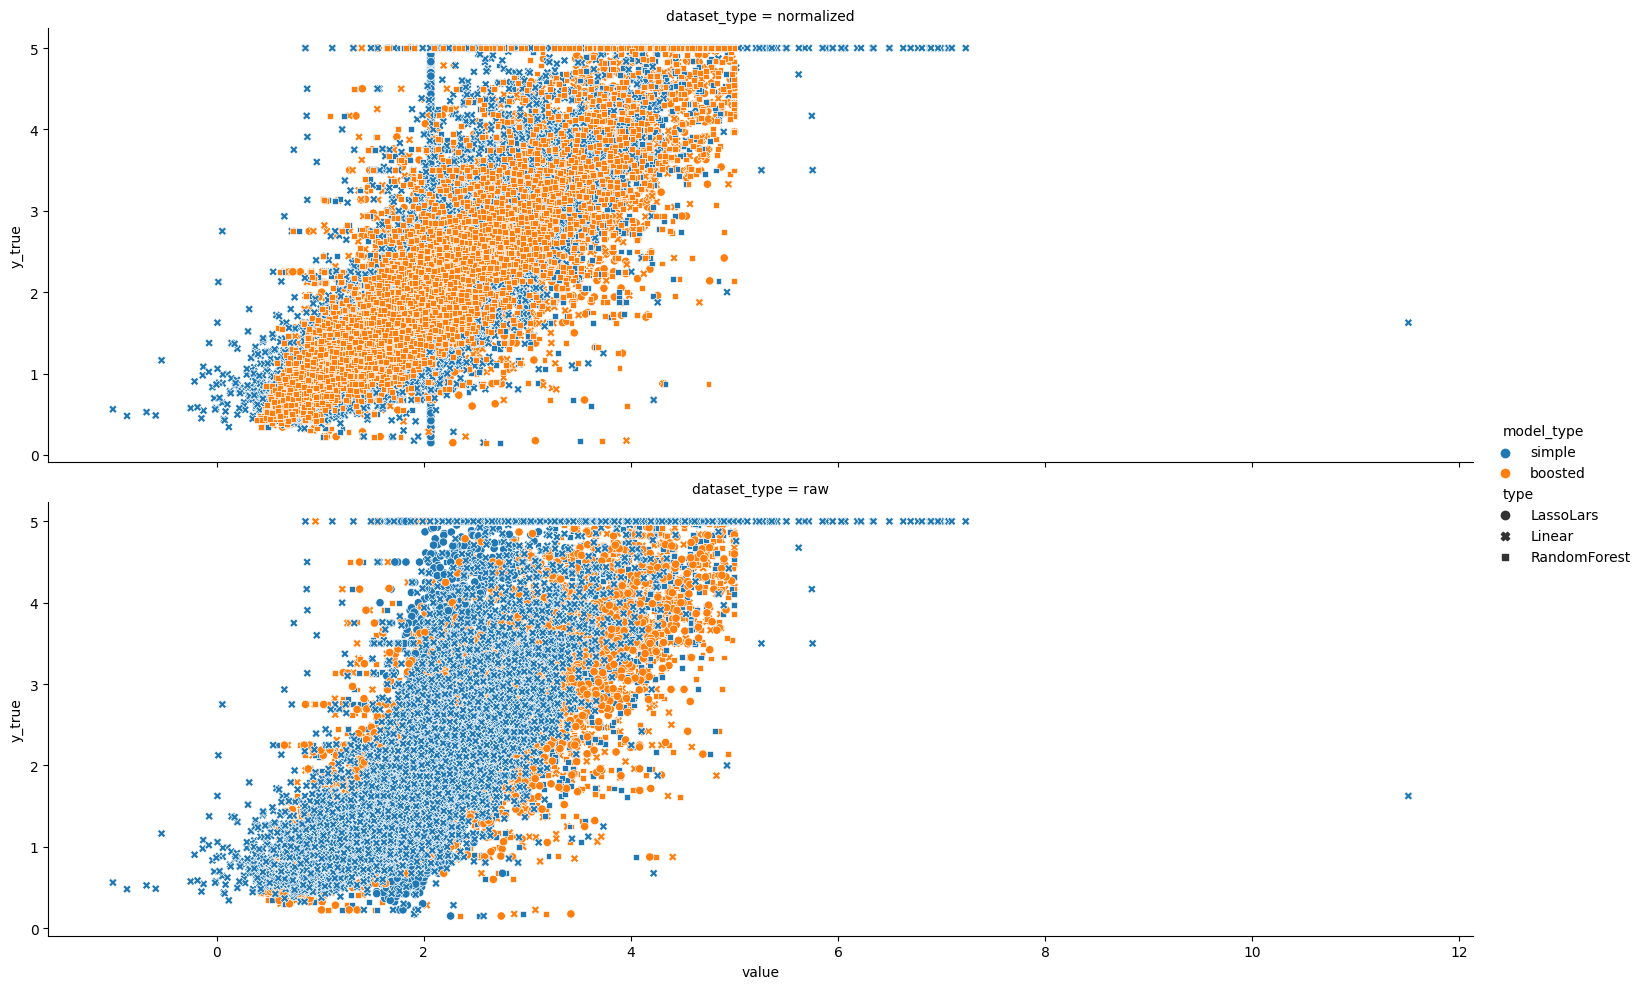

In [53]:
sns.relplot(data=result_df, x="value", y="y_true", row="dataset_type", hue="model_type", style="type", aspect=3)